# Exploration of Sales Data

Snohomish County Parcel Search:  
https://www.snoco.org/proptax/search.aspx?parcel_number= ***PARCELHERE***


In [413]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

### Data from Mongo Database

In [414]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [415]:
db = client['homesales_snohomish']
sales = db.homesales

In [416]:
rows = sales.find()
home_sales = pd.DataFrame(list(rows))
home_sales = home_sales.drop('_id', axis=1)

In [417]:
len(home_sales['Parcel #'].unique())

54029

### Data from csv

In [418]:
# home_sales1 = pd.read_csv(
#     'data/sales.csv',
#     index_col=0,
#     dtype={
#         'Parcel #': str,
#         'Year Built': str,
#         'Type': str,
#         'Quality/Grade': str,
#         'Address': str,
#         'City': str,
#         'Nbhd': str
#     }
# )

## Initial inspection

In [419]:
home_sales.head()

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
0,31051100400500,1/31/2020 12:00:00 AM,"$2,500,000.00",5.44,,,,,21015 STATE ROUTE 9 NE,Arlington,Nbhd:5203000,521
1,00804500000100,1/31/2020 12:00:00 AM,"$416,000.00",0.29,1993,Tri Level,Avg,1430,20911 66TH AVE NE,Arlington,Nbhd:2408000,111
2,00960009607300,1/31/2020 12:00:00 AM,"$75,000.00",0,1996,Dbl Wide,V Good,1620,20227 80TH AVE NE SPC 73,Arlington,Nbhd:2408906,119
3,00874800005200,1/29/2020 12:00:00 AM,"$419,000.00",0.14,2001,1 1/2 Sty,Avg,1813,18127 GREYWALLS DR,Arlington,Nbhd:2408000,111
4,00946600000300,1/29/2020 12:00:00 AM,"$347,000.00",0.1166,2003,1 Sty,Avg-,1348,18722 35TH AVE NE,,Nbhd:2408000,111


In [420]:
home_sales.shape

(66691, 12)

## Data Cleaning

### Filters

#### Dates 

In [421]:
# ********** Clean Dates ***************
datetime.datetime.strptime(
    home_sales['Date of Sale'][0], '%m/%d/%Y %H:%M:%S %p')

datetime.datetime(2020, 1, 31, 12, 0)

In [422]:
def date_clean(d):
    return datetime.datetime.strptime(d, '%m/%d/%Y %H:%M:%S %p')

In [423]:
home_sales['Date of Sale'] = home_sales['Date of Sale'].map(date_clean)

#### Price

In [424]:
# ********** Clean Sale Price **********
def sale_price_clean(price):
    return float(price.strip('$').replace(',',''))

In [425]:
sale_price_clean(home_sales['Sale Price'][0])

2500000.0

In [426]:
home_sales['Sale Price'] = home_sales['Sale Price'].map(sale_price_clean)

#### Use Code, Sqft, Lot Size, 

In [427]:
home_sales['Use Code'] = home_sales['Use Code'].map(int)

In [428]:
def sqft_clean(sqft):
    if sqft:
        return float(sqft)
    else:
        return None

In [429]:
home_sales['Sqft'] = home_sales['Sqft'].map(sqft_clean)

In [430]:
home_sales['Lot Size'] = home_sales['Lot Size'].map(float)

In [431]:
def year_built_clean(year):
    if year:
        return int(year)
    else:
        return None

In [432]:
home_sales['Year Built'] = home_sales['Year Built'].map(year_built_clean)

#### Neighborhood

In [433]:
home_sales['Nbhd'][0].split(':')[1]

'5203000'

In [434]:
home_sales['Nbhd'] = home_sales['Nbhd'].map(lambda n: n.split(':')[1])

#### City

In [435]:
home_sales['City'].unique()

array(['Arlington', '', 'Bothell', 'Brier', 'Darrington', 'Edmonds',
       'Everett', 'Lynnwood', 'Goldbar', 'Granite Falls', 'Lake Stevens',
       'Marysville', 'Stanwood', 'Mill Creek', 'Monroe',
       'Mountlake Terrace', 'MUKILTEO', 'Snohomish', 'Sultan', 'Woodway',
       'BOT        Bothell', 'MIL        Mill Creek', 'LAKESTEVENS',
       'LYN        Lynnwood', 'BRI        Brier', 'Index', 'GF',
       'MILLCREEK', 'EDM        Edmonds', 'Woodinville', 'Mukilteo',
       'EVEEverett', 'STA        Stanwood', 'UNKNOWN'], dtype=object)

In [436]:
wrong_city = {
    'BOT        Bothell': 'Bothell',
    'MIL        Mill Creek': 'Mill Creek',
    'LAKESTEVENS': 'Lake Stevens',
    'LYN        Lynnwood': 'Lynnwood',
    'BRI        Brier': 'Brier',
    'GF': 'Granite Falls',
    'MILLCREEK': 'Mill Creek',
    'EDM        Edmonds': 'Edmonds',
    'MUKILTEO': 'Mukilteo',
    'EVEEverett': 'Everett',
    'STA        Stanwood': 'Stanwood',
    'UNKNOWN': ''
}
def clean_city(city):
    if city in wrong_city:
        return wrong_city[city]
    return city

In [437]:
home_sales['City'] = home_sales['City'].map(clean_city)

### Remove bad data

In [438]:
home_sales[home_sales['Year Built'] > 2021]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
2087,27052000205700,2020-03-04 12:00:00,462000.0,0.0502,2103.0,2+ Sty,Avg+,1773.0,2115 201ST PL SE UNIT R-102,,5608000,142
35457,01119900000600,2018-05-16 12:00:00,457000.0,0.0626,6619136.0,2 Sty,Avg+,1763.0,1129 120TH ST SE,,3311001,116
36221,00820700004200,2018-05-17 12:00:00,352000.0,0.2200,6619136.0,1 Sty,Avg-,1456.0,4105 122ND ST NE,Marysville,2413000,111
40715,01133200008300,2018-02-08 12:00:00,806000.0,0.0816,6619136.0,2 Sty,Avg+,2583.0,17018 40TH AVE SE,,3413000,111


In [439]:
# Removing rows where Year Built is greater than current year
home_sales.drop(home_sales[home_sales['Year Built'] > 2021].index, inplace=True)

Take a look at duplicates

#### Sales where parcel and date are same

In [440]:
# Create unique sales

home_sales['sale_id'] = home_sales['Parcel #'] + home_sales['Date of Sale'].map(str)

In [441]:
home_sales.iloc[0]['sale_id']

'310511004005002020-01-31 12:00:00'

In [442]:
# Sales with more than 1 entry
(home_sales.groupby('sale_id')['sale_id'].value_counts() > 1).count()

60421

In [443]:
unique_sales = home_sales.groupby('sale_id')['sale_id'].value_counts()

In [444]:
len(unique_sales[unique_sales > 1])

4851

In [445]:
home_sales = home_sales.drop_duplicates('sale_id', keep=False)

#### sales where price and date are same

In [446]:
home_sales['batch'] =  home_sales['Date of Sale'].map(str) + home_sales['Sale Price'].map(str)

In [447]:
batched_sales = home_sales.groupby('batch')['batch'].value_counts()

In [448]:
len(batched_sales[batched_sales > 1])

3949

In [449]:
home_sales = home_sales.drop_duplicates('batch', keep=False)

In [450]:
len(home_sales)

44822

#### Remove no sqft

In [451]:
home_sales = home_sales[home_sales['Sqft']>100]

#### remove bad year built

In [452]:
home_sales[home_sales['Year Built']<1850]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code,sale_id,batch
17418,00601500101501,2019-04-26 12:00:00,254000.0,0.2117,0.0,,,984.0,402 E STANLEY ST,Granite Falls,5103000,581,006015001015012019-04-26 12:00:00,2019-04-26 12:00:00254000.0
30639,01167700000800,2018-07-13 12:00:00,671782.0,0.0749,0.0,2 Sty,Avg+,1622.0,4510 187TH PL SE,,3511000,111,011677000008002018-07-13 12:00:00,2018-07-13 12:00:00671782.0


In [453]:
home_sales = home_sales[home_sales['Year Built']>1850]

#### Remove too low price

In [454]:
home_sales = home_sales[home_sales['Sale Price']>25000]

## Looking at data

In [455]:
np.sort(home_sales['Use Code'].unique())

array([  1, 110, 111, 112, 116, 117, 118, 119, 121, 122, 123, 124, 130,
       131, 132, 133, 135, 138, 139, 141, 142, 143, 144, 145, 150, 160,
       162, 163, 174, 179, 183, 184, 185, 186, 188, 189, 198, 249, 342,
       390, 429, 431, 504, 506, 518, 519, 539, 551, 559, 569, 581, 591,
       599, 614, 615, 623, 629, 637, 639, 641, 651, 652, 659, 662, 681,
       691, 692, 699, 830, 880, 881, 889, 890, 910, 911, 914, 940, 941,
       950])

In [456]:
use_codes = np.load('data/use_codes.npy', allow_pickle='TRUE').item()

In [457]:
# drop rows where Use Code = 1
home_sales.drop(home_sales[home_sales['Use Code']==1].index, inplace=True)

We only want properties where people are living

In [458]:
home_sales = home_sales[home_sales['Use Code']<150]

In [459]:
home_sales.groupby('Use Code')['Use Code'].count()

Use Code
110        3
111    30531
112        5
116     1352
117       57
118      992
119      829
121       48
122      372
123       38
124       22
130       13
131        5
132        1
133        2
135        1
138        1
139        3
141     2417
142      641
143     2900
144        1
145      653
Name: Use Code, dtype: int64

In [460]:
home_sales.groupby('Type')['Type'].count()

Type
                  12
1 1/2 Sty        929
1 1/2 Sty B      512
1 Sty          11747
1 Sty B         2258
2 Sty          15724
2 Sty B         1461
2+ Sty          1872
2+ Sty B          31
Dbl Wide        1571
Dbl Wide B         5
Multi Level        6
Quad Level         6
Sgl Wide         260
Split Entry     3137
Tri Level       1299
Trpl Wide         57
Name: Type, dtype: int64

In [461]:
# home_sales[
#     (home_sales['Use Code']<150) & 
#     (home_sales['Type']=='2+ Sty') & 
#     (home_sales['Use Code']== 111)
# ]


In [462]:
# removed 112, 144
sfr_codes = [111,113,114,115,116,118,141,142,145]

#### Create dataframe for just single family residences

In [463]:
single_family = home_sales[home_sales['Use Code'].isin(sfr_codes)].copy()

In [464]:
single_family.head(3)

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code,sale_id,batch
1,00804500000100,2020-01-31 12:00:00,416000.0,0.2900,1993.0,Tri Level,Avg,1430.0,20911 66TH AVE NE,Arlington,2408000,111,008045000001002020-01-31 12:00:00,2020-01-31 12:00:00416000.0
3,00874800005200,2020-01-29 12:00:00,419000.0,0.1400,2001.0,1 1/2 Sty,Avg,1813.0,18127 GREYWALLS DR,Arlington,2408000,111,008748000052002020-01-29 12:00:00,2020-01-29 12:00:00419000.0
4,00946600000300,2020-01-29 12:00:00,347000.0,0.1166,2003.0,1 Sty,Avg-,1348.0,18722 35TH AVE NE,,2408000,111,009466000003002020-01-29 12:00:00,2020-01-29 12:00:00347000.0


In [465]:
home_sales['City'].unique()

array(['Arlington', '', 'Bothell', 'Brier', 'Darrington', 'Edmonds',
       'Everett', 'Lynnwood', 'Goldbar', 'Granite Falls', 'Lake Stevens',
       'Marysville', 'Stanwood', 'Mill Creek', 'Monroe',
       'Mountlake Terrace', 'Mukilteo', 'Snohomish', 'Sultan', 'Woodway',
       'Woodinville', 'Index'], dtype=object)

## Exploration

In [466]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
     '#bcbd22', '#17becf']
colors = c + c

In [467]:
single_family['price/sqft'] = single_family['Sale Price']/single_family['Sqft']

In [468]:
single_family= single_family[single_family['price/sqft']<2000]

#### Look for extremes

In [469]:
len(single_family[single_family['Sale Price'] < 10000])

0

In [470]:
len(single_family[single_family['Sale Price'] > 10000000])

0

In [471]:
single_family[single_family['Sqft'] < 200]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code,sale_id,batch,price/sqft
25435,01049400210200,2018-10-11 12:00:00,27000.0,0.00,1997.0,1 Sty,Avg,115.0,12006 NE 204TH PL UNIT B102,,5620801,145,010494002102002018-10-11 12:00:00,2018-10-11 12:00:0027000.0,234.782609
26432,00556600009800,2018-10-26 12:00:00,295000.0,1.05,2005.0,Dbl Wide,Good,171.0,27103 176TH PL SE,,4120000,118,005566000098002018-10-26 12:00:00,2018-10-26 12:00:00295000.0,1725.146199


In [472]:
single_family.groupby('Use Code').mean()

,Sale Price,Lot Size,Year Built,Sqft,price/sqft
Use Code,,,,,
111,505821.602784,0.818761,1986.864854,2131.657583,246.760307
116,424892.168024,0.049476,2011.596595,1717.527017,249.640811
118,265067.911201,1.955308,1988.578204,1429.197275,193.544043
141,481807.489036,0.005855,2010.342987,1992.887878,244.019645
142,359489.296412,0.005348,2003.890796,1555.452418,232.178455
145,240347.569678,0.000000,1995.196018,909.166922,267.177979


In [473]:
fonts = {'fontsize':16, 'fontfamily':'serif'}

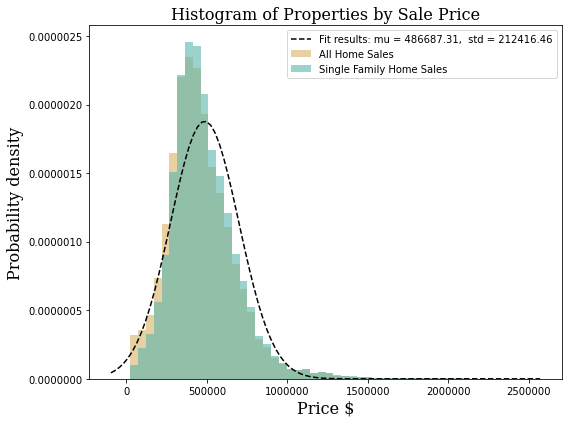

In [474]:
fig, ax = plt.subplots(figsize=(8,6))

# mu = single_family['Sale Price'].mean()
# std = single_family['Sale Price'].std()
home_sale_prices = home_sales[
    (home_sales['Sale Price'] < 2500000)]['Sale Price']
single_family_prices = single_family[
    (single_family['Sale Price'] < 2500000)]['Sale Price']

ax.hist(home_sale_prices, 
        bins=50, 
        density=True, 
        alpha=.6, 
        color='#d8b365',
        label='All Home Sales')
n, bins, patches = ax.hist(single_family_prices, 
                           bins=50,
                           density=True, 
                           color='#5ab4ac', 
                           alpha=.6, 
                           label='Single Family Home Sales')


mu, std = stats.norm.fit(single_family_prices)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k--',label = "Fit results: mu = %.2f,  std = %.2f" % (mu, std))


# fit = stats.norm(loc=mu, scale=std).pdf(bins)
# ax.plot(bins,fit,'--')
# ax.set_xlim(0,2500000)
ax.set_xlabel('Price $', **fonts)
ax.set_ylabel('Probability density', **fonts)
ax.set_title('Histogram of Properties by Sale Price', **fonts)
ax.ticklabel_format(style='plain')
fig.tight_layout()
plt.legend()
plt.show()

In [475]:
mean_per_day = single_family.groupby('Date of Sale')['Sale Price'].mean()

In [476]:
# mean_per_day.index

In [477]:
# mean_per_day.rolling(3).mean()

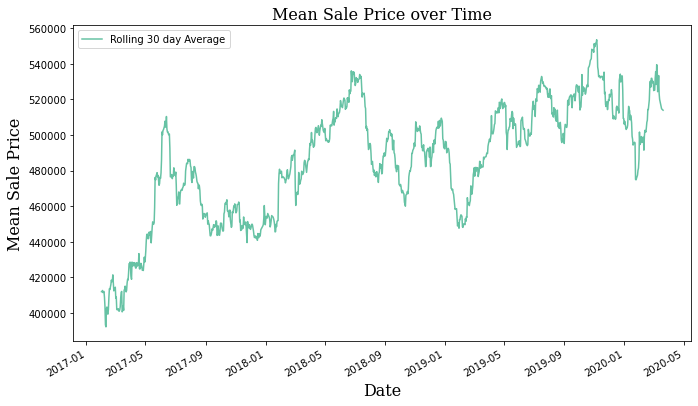

In [478]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(mean_per_day.rolling(30).mean(), color='#66c2a4', label='Rolling 30 day Average')
ax.set_xlabel('Date', **fonts)
ax.set_ylabel('Mean Sale Price', **fonts)
ax.set_title('Mean Sale Price over Time', **fonts)
fig.tight_layout()
fig.autofmt_xdate()
plt.legend()
plt.show()

In [479]:
single_family.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36583 entries, 1 to 66685
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Parcel #       36583 non-null  object        
 1   Date of Sale   36583 non-null  datetime64[ns]
 2   Sale Price     36583 non-null  float64       
 3   Lot Size       36583 non-null  float64       
 4   Year Built     36583 non-null  float64       
 5   Type           36583 non-null  object        
 6   Quality/Grade  36583 non-null  object        
 7   Sqft           36583 non-null  float64       
 8   Address        36583 non-null  object        
 9   City           36583 non-null  object        
 10  Nbhd           36583 non-null  object        
 11  Use Code       36583 non-null  int64         
 12  sale_id        36583 non-null  object        
 13  batch          36583 non-null  object        
 14  price/sqft     36583 non-null  float64       
dtypes: datetime64[ns](1

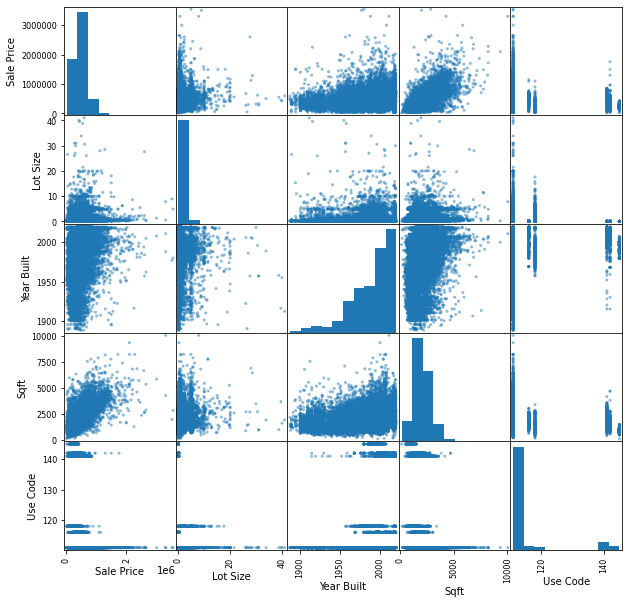

In [480]:
pd.plotting.scatter_matrix(
    single_family[
        single_family['Lot Size']<100
    ][[
        'Date of Sale', 
        'Sale Price',
        'Lot Size',
        'Year Built',
        'Type',
        'Quality/Grade',
        'Sqft',
        'Nbhd',
        'Use Code'
    ]], figsize=(10,10));

In [481]:
codes = np.sort(single_family['Use Code'].unique())

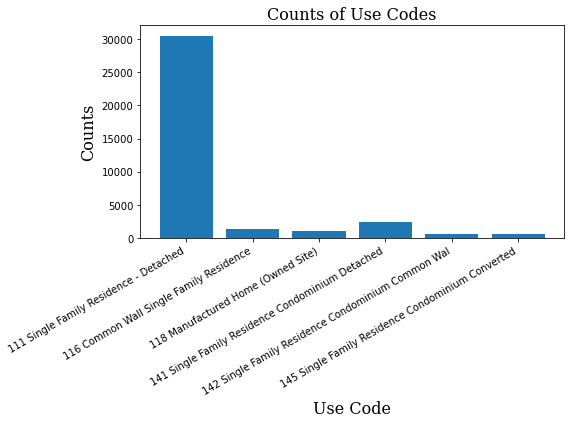

In [482]:
fig, ax = plt.subplots(figsize=(8,6))

ax.bar([use_codes[code] for code in codes], 
       single_family.groupby('Use Code')['Use Code'].value_counts())

ax.set_xlabel('Use Code', **fonts)
ax.set_ylabel('Counts', **fonts)
ax.set_title('Counts of Use Codes', **fonts)

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [483]:
sf_2019_6000sq = single_family[
    (single_family['Date of Sale']>np.datetime64('2018-12-31'))& 
    (single_family['Date of Sale']<np.datetime64('2020-01-01'))&
    (single_family['Sqft']<6000)
]

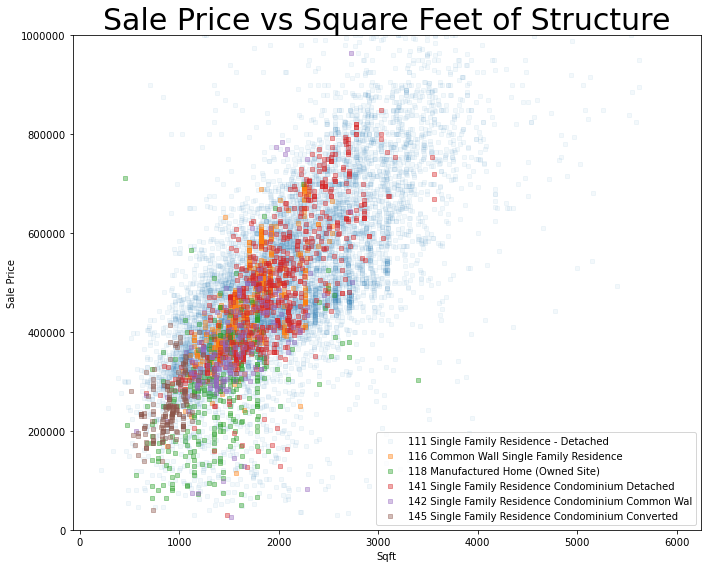

In [486]:

fig, ax = plt.subplots(figsize=(10,8))
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 'Sale Price', 
        color=colors[i],
        marker=',',
        alpha=(.05 if code==111 else 0.4), ax=ax,
        label="{}".format(use_codes[code]))
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()

In [487]:
# single_family.info()

In [488]:
p_sqft_means = sf_2019_6000sq.groupby('Use Code')['price/sqft'].mean()
p_sqft_means

Use Code
111    260.983450
116    270.971499
118    208.503950
141    252.404748
142    244.517967
145    282.942708
Name: price/sqft, dtype: float64

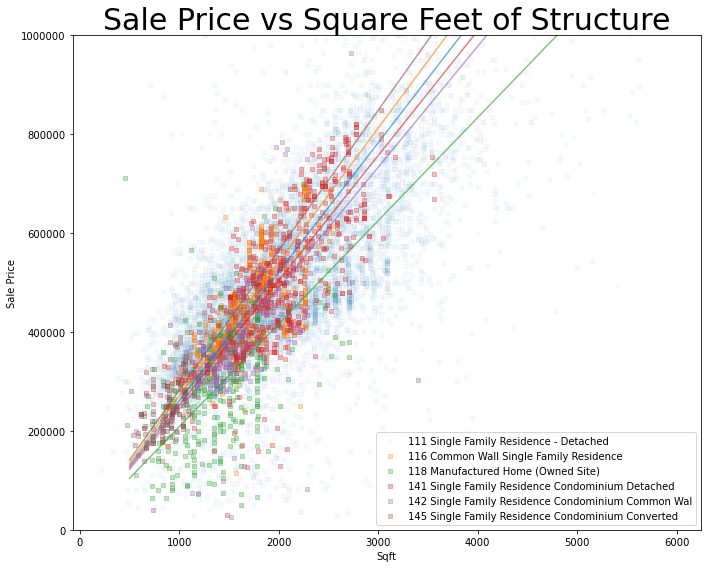

In [490]:
fig, ax = plt.subplots(figsize=(10,8))
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 'Sale Price', 
        color=colors[i],
        marker=',',
        alpha=(.03 if code==111 else 0.3), ax=ax,
        label="{}".format(use_codes[code]))
    ax.plot([500,5000], np.array([500,5000])*p_sqft_means[code],color=colors[i], alpha=.6)
    
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()

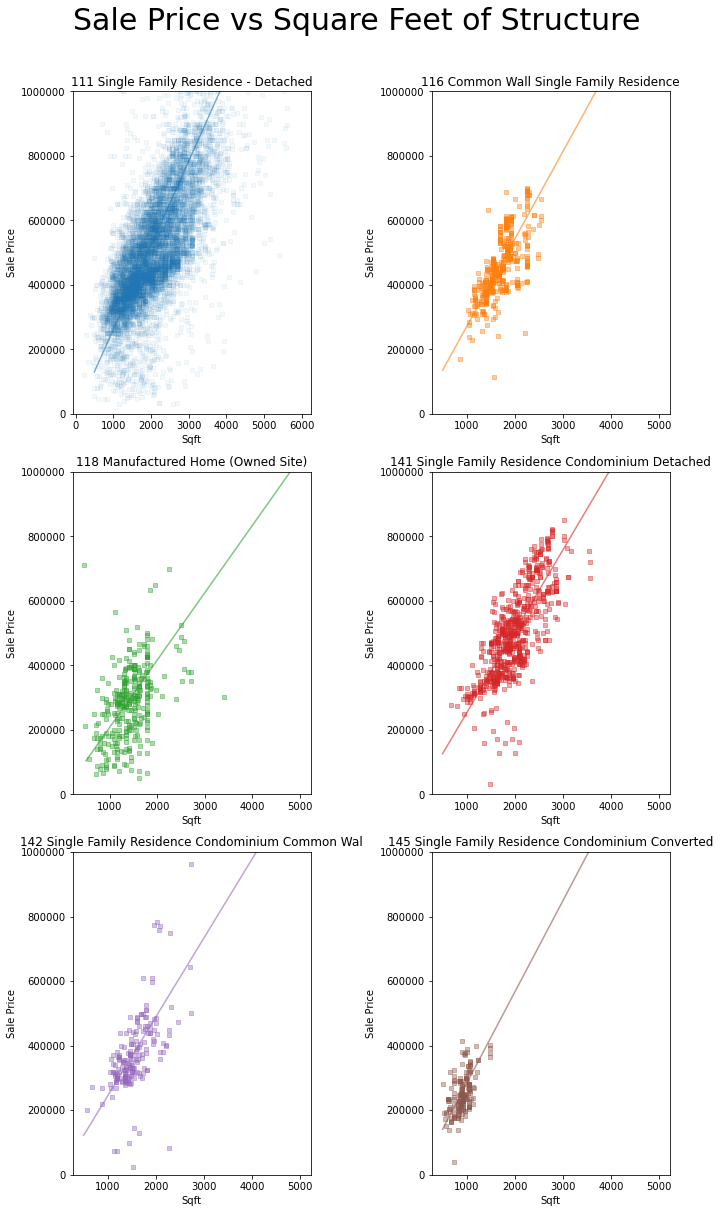

In [491]:
fig, ax1 = plt.subplots(3,2,figsize=(10,16))
axes = ax1.flatten()
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 
        'Sale Price',
        color=colors[i],
        marker=',',
        alpha=(.05 if code==111 else 0.4), 
        ax=axes[i])
    
    axes[i].plot([500,5000], np.array([500,5000])*p_sqft_means[code],
                 color=colors[i],
                 alpha=.6)
    axes[i].set_ylim(0,1000000)
    axes[i].set_title("{}".format(use_codes[code]))
    axes[i].ticklabel_format(style='plain')

fig.suptitle('Sale Price vs Square Feet of Structure',x=.5, y=1.05, size=30)
fig.tight_layout()
plt.show()

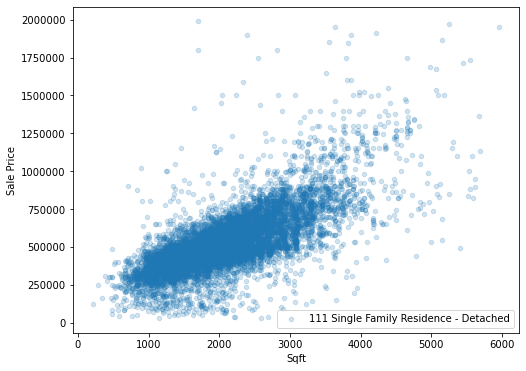

In [492]:
fig, ax = plt.subplots(figsize=(8,6))
sf_2019_6000sq[
    (sf_2019_6000sq["Use Code"] == 111) &
    (sf_2019_6000sq["Sale Price"] < 2000000)
].plot.scatter(
    'Sqft', 'Sale Price', 
    color=colors[0],
    alpha=0.2, 
    ax=ax,
    label="{}".format(use_codes[111]))
ax.ticklabel_format(style='plain');

In [493]:
single_family['Quality/Grade'].unique()

array(['Avg', 'Avg-', 'Good', 'Avg+', 'Fair', 'V Good', 'Low', 'Sub Std',
       'Excellent'], dtype=object)

### t-test for Use Codes

Lets find out if the price/sqft distributions are normal

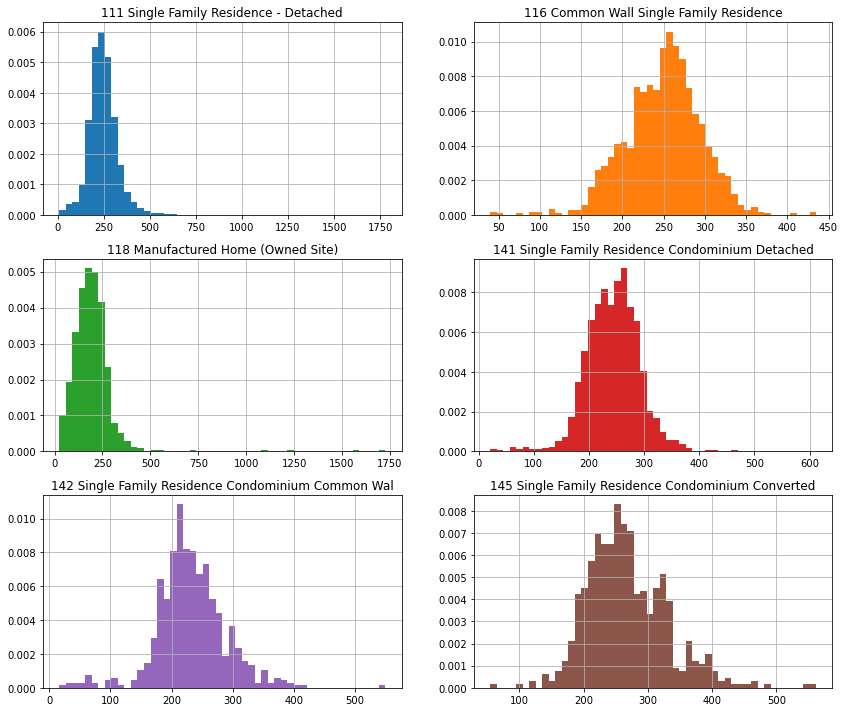

In [494]:
fig, ax1 = plt.subplots(3,2, figsize=(12,10))
axes = ax1.flatten()
for i, code in enumerate(codes):
    single_family[single_family["Use Code"] == code].hist(
        'price/sqft',
        bins=50,
        density=True,
        color=colors[i],
        ax=axes[i])

    axes[i].set_title("{}".format(use_codes[code]))

# fig.suptitle('Sale Price vs Square Feet of Structure',x=.5, y=1.05, size=30)
fig.tight_layout()
plt.show()

We want to see if Use Code has statistical significance when comparing price per square foot.  
Because there is little risk we will set $\alpha$ at 0.1

In [495]:
single_family.groupby('Use Code')['Use Code'].value_counts()

Use Code  Use Code
111       111         30530
116       116          1351
118       118           991
141       141          2417
142       142           641
145       145           653
Name: Use Code, dtype: int64

In [496]:
codes

array([111, 116, 118, 141, 142, 145])

In [497]:
code_ttests = []

In [498]:
for code1, code2 in combinations(codes, 2):
    s, p = stats.ttest_ind(
        single_family[single_family['Use Code']==code1]['price/sqft'],
        single_family[single_family['Use Code']==code2]['price/sqft'])
    code_ttests.append((code1, code2, s, p))

In [499]:
print('Statistical significance in price/sqft between Use Codes')
for code1, code2, s, p in code_ttests:
    if p<.1:
        print('{} and {} are different. P value of {:.4f}'.format(code1,code2,p))
    else:
        print('{} and {} are the same. P value of {:.4f}'.format(code1,code2,p))

Statistical significance in price/sqft between Use Codes
111 and 116 are the same. P value of 0.1953
111 and 118 are different. P value of 0.0000
111 and 141 are the same. P value of 0.1018
111 and 142 are different. P value of 0.0000
111 and 145 are different. P value of 0.0000
116 and 118 are different. P value of 0.0000
116 and 141 are different. P value of 0.0005
116 and 142 are different. P value of 0.0000
116 and 145 are different. P value of 0.0000
118 and 141 are different. P value of 0.0000
118 and 142 are different. P value of 0.0000
118 and 145 are different. P value of 0.0000
141 and 142 are different. P value of 0.0000
141 and 145 are different. P value of 0.0000
142 and 145 are different. P value of 0.0000


### By type

In [500]:
types = np.sort(single_family['Type'].unique())

In [551]:
sf_types = single_family[single_family['Use Code']==111].groupby('Type').filter(lambda typ: len(typ)>50)

In [552]:
types = np.sort(sf_types['Type'].unique())

In [553]:
sf_types = sf_types[sf_types['price/sqft']<800]
sf_types.groupby('Type')['Type'].value_counts()

Type         Type       
1 1/2 Sty    1 1/2 Sty        896
1 1/2 Sty B  1 1/2 Sty B      490
1 Sty        1 Sty           8949
1 Sty B      1 Sty B         2193
2 Sty        2 Sty          12152
2 Sty B      2 Sty B         1175
2+ Sty       2+ Sty           290
Split Entry  Split Entry     3029
Tri Level    Tri Level       1282
Name: Type, dtype: int64

In [554]:
types

array(['1 1/2 Sty', '1 1/2 Sty B', '1 Sty', '1 Sty B', '2 Sty', '2 Sty B',
       '2+ Sty', 'Split Entry', 'Tri Level'], dtype=object)

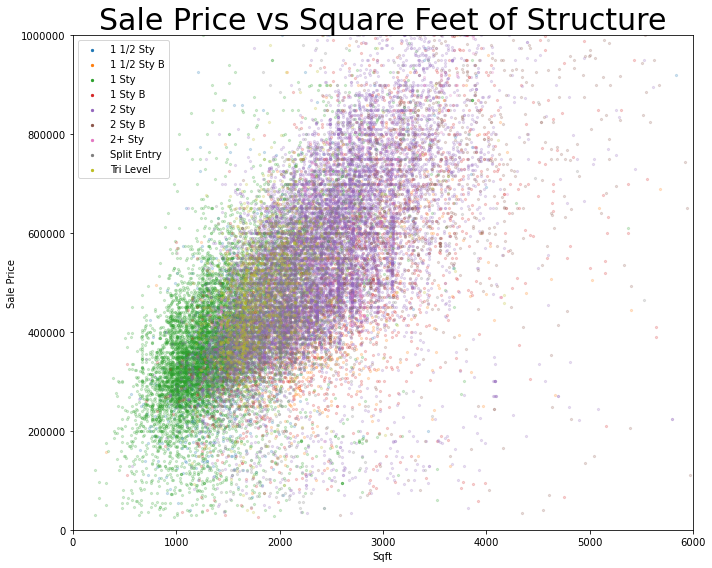

In [555]:
fig, ax = plt.subplots(figsize=(10,8))
for i, typ in enumerate(types):
    sf_types[(sf_types['Type']==typ) ].plot.scatter(
        'Sqft', 'Sale Price',
        marker='.',
        color=colors[i],
        alpha=.2, ax=ax,
        label="{}".format(typ))
ax.set_ylim(0,1000000)
ax.set_xlim(0,6000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.tight_layout()

In [556]:
len(types)

9

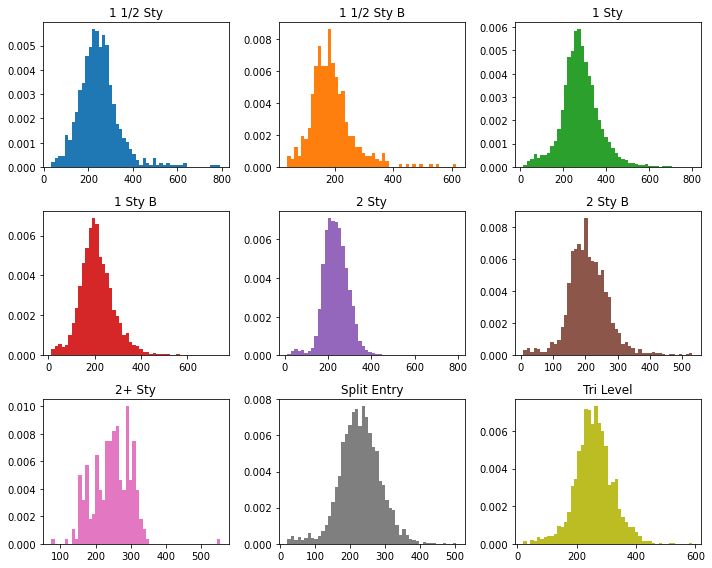

In [557]:
fig, ax1 = plt.subplots(3,3,figsize=(10,8))
axes = ax1.flatten()
for i, ax in enumerate(axes):
    ax.hist(
        sf_types[(sf_types['Type']==types[i]) ]['price/sqft'],
        bins=50,
        density=True,
        color=colors[i])
    ax.set_title("{}".format(types[i]))

# ax.set_title('Histograms for types', size=30)
# ax.ticklabel_format(style='plain')
fig.tight_layout()

In [559]:
type_ttests = []

In [560]:
for type1, type2 in combinations(types, 2):
    s, p = stats.ttest_ind(
        sf_types[sf_types['Type']==type1]['price/sqft'],
        sf_types[sf_types['Type']==type2]['price/sqft'])
    type_ttests.append((type1, type2, s, p))

In [561]:
print('Statistical significance in price/sqft between Types of Properties:')
for type1, type2, s, p in type_ttests:
    if p<.15:
        print('{} and {} are different. P value of {:.4f}'.format(type1,type2,p))
    else:
        print('{} and {} are the same. P value of {:.4f}'.format(type1,type2,p))

Statistical significance in price/sqft between Types of Properties:
1 1/2 Sty and 1 1/2 Sty B are different. P value of 0.0000
1 1/2 Sty and 1 Sty are different. P value of 0.0000
1 1/2 Sty and 1 Sty B are different. P value of 0.0000
1 1/2 Sty and 2 Sty are different. P value of 0.0000
1 1/2 Sty and 2 Sty B are different. P value of 0.0000
1 1/2 Sty and 2+ Sty are the same. P value of 0.8917
1 1/2 Sty and Split Entry are different. P value of 0.0000
1 1/2 Sty and Tri Level are different. P value of 0.0005
1 1/2 Sty B and 1 Sty are different. P value of 0.0000
1 1/2 Sty B and 1 Sty B are different. P value of 0.0000
1 1/2 Sty B and 2 Sty are different. P value of 0.0000
1 1/2 Sty B and 2 Sty B are different. P value of 0.0000
1 1/2 Sty B and 2+ Sty are different. P value of 0.0000
1 1/2 Sty B and Split Entry are different. P value of 0.0000
1 1/2 Sty B and Tri Level are different. P value of 0.0000
1 Sty and 1 Sty B are different. P value of 0.0000
1 Sty and 2 Sty are different. P valu

In [562]:
sf_types.groupby('Type')['price/sqft'].mean()

Type
1 1/2 Sty      246.515688
1 1/2 Sty B    187.178197
1 Sty          280.261397
1 Sty B        211.763840
2 Sty          236.200050
2 Sty B        209.557637
2+ Sty         247.280737
Split Entry    227.671631
Tri Level      258.093465
Name: price/sqft, dtype: float64

In [564]:
sf_types.groupby('Type')['Type'].value_counts()

Type         Type       
1 1/2 Sty    1 1/2 Sty        896
1 1/2 Sty B  1 1/2 Sty B      490
1 Sty        1 Sty           8949
1 Sty B      1 Sty B         2193
2 Sty        2 Sty          12152
2 Sty B      2 Sty B         1175
2+ Sty       2+ Sty           290
Split Entry  Split Entry     3029
Tri Level    Tri Level       1282
Name: Type, dtype: int64

### t-tests for Grade

In [579]:
quals = single_family.groupby('Quality/Grade')

In [567]:
qualities = ['Sub Std', 'Low', 'Fair', 'Avg-','Avg', 'Avg+', 'Good', 'V Good', 'Excellent']

In [594]:
[len(group[1]) for group in quals]

[17801, 7281, 2841, 44, 4318, 3160, 557, 26, 555]

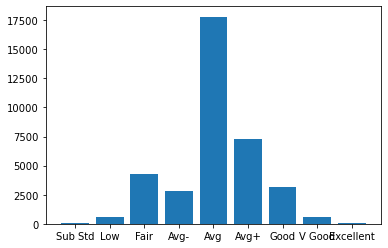

In [592]:
fig, ax = plt.subplots()

ax.bar(qualities, [len(single_family[single_family['Quality/Grade']==qual]) for qual in qualities]);

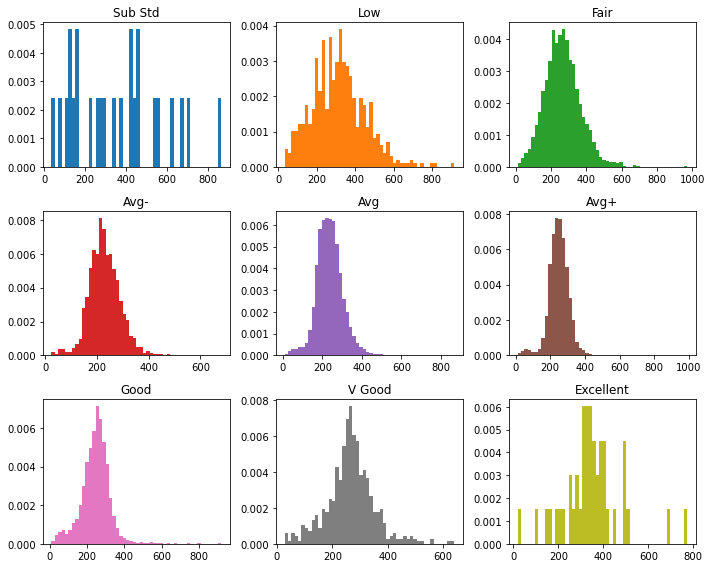

In [602]:
fig, ax1 = plt.subplots(3,3,figsize=(10,8))
axes = ax1.flatten()
for i, ax in enumerate(axes):
    ax.hist(
        single_family[
            (single_family['Quality/Grade']==qualities[i]) & 
            (single_family['price/sqft']<1000)]['price/sqft'],
        bins=50,
        density=True,
        color=colors[i])
    ax.set_title("{}".format(qualities[i]))

# ax.set_title('Histograms for types', size=30)
# ax.ticklabel_format(style='plain')
fig.tight_layout()

In [603]:
quality_ttests = []